# 시계열 예측 튜토리얼(Time Series Forecasting Tutorial)

참고 : https://www.tensorflow.org/tutorials/structured_data/time_series

---
### Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import os
import datetime
import IPython
import IPython.display

In [2]:
# M1 개발환경에서 TensorFlow를 사용하기 위한 코드입니다.
# M1 개발환경이 아닐경우 생략합니다.
from tensorflow.python.compiler.mlcompute import mlcompute
#tf.compat.v1.disable_eager_execution()
mlcompute.set_mlc_device(device_name = 'any')

---
## 수집(Acquision)

이번 시계열 예측 튜토리얼에서 Jena Climate dataset(recorded by the [Max Planck Institute for Biogeochemistry][link])을 사용하였습니다.

이 데이터는 독일 Jena지역에서 2009년 1월 10일부터 2016년 12월 31일까지 10분 간격으로 측정된 14가지 특성으로 이루어져있습니다.


[link]: https://www.bgc-jena.mpg.de/wetter/

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')

---
## 점검 및 탐색(Inspection and exploratin)

데이터 구조를 파악하기 위해, 처음 5개의 행만 출력하여 데이터를 확인합니다.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


데이터는 시간부분을 제외하고 온도, 대기압, 습도, 풍속, 풍향 등 14개의 특성을 가지고 있습니다.<br>데이터는 10분 간격으로 나타나있으며 하루에 144개의 데이터가 기록됩니다.

`df.describe()`을 사용하여 데이터의 분포와 통계를 살펴겠습니다.<br>그리고 몇 가지 특성에 대해서는 시각화를 하기 위해 그래프로 나타내겠습니다.

In [5]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [6]:
# 데이터프레임 d.m.Y H:M:S 형식으로 표현되어있는 Date Time 열을 Y-m-d H:M:S 형식으로 변경하고 따로 저장합니다.
date_time = pd.to_datetime(df.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')

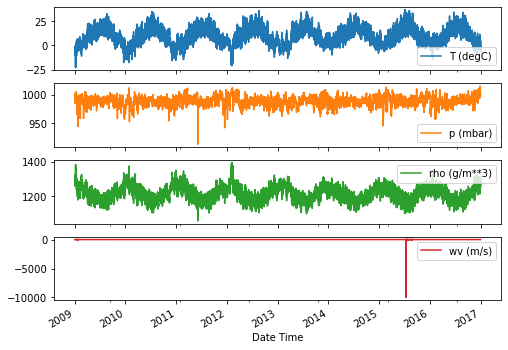

In [7]:
# matplotlib 차트의 기본 설정
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] =False

# 기온(T), 대기압(mbar), 공기밀도(rho), 풍속(wv) 네 가지 특성에 대해 그래프로 나타냅니다.
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

`df.describe()`과 그래프를 통하여 데이터를 확인한 결과, 다른 특성들에서는 시간에 따른 변화가 나타나지만 풍속과 최대풍속을 나타내는 특성인 `wv` , `max. wv`에 이상이 있다고 판단됩니다.

---
## 전처리 및 정제(Preprocessing and Cleaning)

데이터 구조에 대한 파악 이후 학습 진행에 용이하도록 데이터 전처리를 수행합니다.<br>이전 단계에서 데이터를 살펴본 결과, `wv`, `max. wv`특성에서 최소값 `-9999`이 나타나는 것을 확인 할 수 있었습니다.

풍향에 대한 특성 `wd`가 따로 존재하기 때문에 풍속의 값은 스칼라 값으로 `>=0`의 값을 가져야합니다.<br>따라서 해당 값을 `0`으로 대체하겠습니다.

In [8]:
wv = df['wv (m/s)']
# wv에서 -9999.0 값을 가지는 열의 index를 minus_wv에 저장합니다.
minus_wv = wv == -9999.0
# wv에서 minus_wv 인덱스에 해당하는 값들을 0.0으로 변환합니다.
wv[minus_wv] = 0.0

# wv에 대해 수행했던 작업을 max. wv에도 수행합니다.
max_wv = df['max. wv (m/s)']
minus_max_wv = max_wv == -9999.0
max_wv[minus_max_wv] = 0.0

음수값 `-9999.0`이 나타나던 `wv`, `max. wv`값을 0으로 대체하였으니, 다시 그래프를 그려보겠습니다.

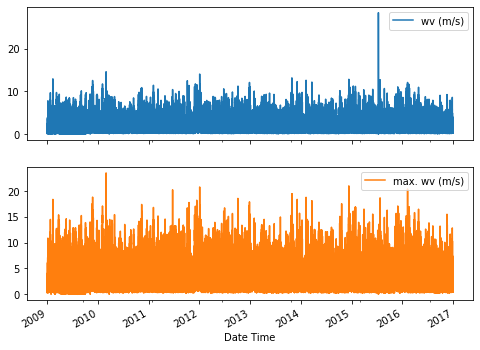

In [9]:
plot_cols = ['wv (m/s)', 'max. wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

---
데이터의 마지막 특성은 `wd (deg)`로 바람의 방향을 나타내고 있습니다.<br>해당 특성에 대해서 그래프로 나타내면 다음과 같습니다.

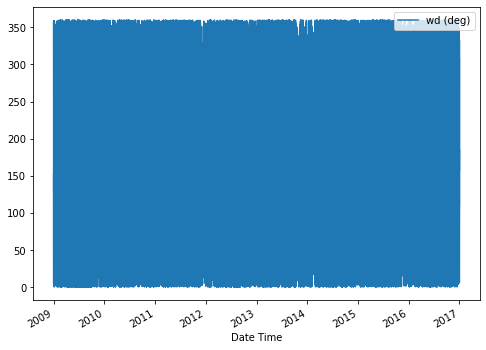

In [10]:
plot_cols = ['wd (deg)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

학습을 진행할 때 모델에 적절한 형식의 데이터를 전달해야하는데, 바람의 방향에 대한 그래프를 확인해보면 모델 입력으로 좋지 않은 모습을 나타내고 있습니다.

이는 바람의 방향을 각도로 표시하였기 때문에 나타나는 현상입니다. <br>360도와 0도는 사실상 같은 값이기 때문에 동일한 특성을 가져야 합니다.

이러한 문제를 해결하기 위해서 풍향과 풍속 데이터를 합쳐 바람에 대한 정보를 하나의 벡터로 나타내도록 하겠습니다.

In [11]:
# 풍속과 관련되어있는 데이터를 wv, max_wv로 저장합니다.
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 풍향의 경우 각도로 표시되어있는 값을 라디안 값으로 변환하여 저장합니다.
wd_rad = df.pop('wd (deg)') * np.pi / 180

# 풍속 데이터, 라디안값으로 변환한 풍향데이터, 삼각함수를 사용하여
# 풍속과 풍향을 벡터값으로 합쳐 데이터프레임에 추가합니다.
df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

df['max Wx'] = max_wv * np.cos(wd_rad)
df['max Wy'] = max_wv * np.sin(wd_rad)

벡터값으로 변환한 데이터를 그래프로 그려보면 다음과 같습니다.

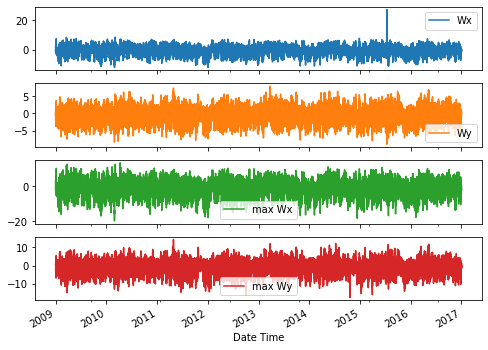

In [12]:
plot_cols = ['Wx', 'Wy', 'max Wx', 'max Wy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

풍속에 관한 특성인 `wv`, `max. wv`에 대해서 방향을 나타내는 특성인 `wd`를 조합하여 벡터값으로 변환하여 그래프로 표현하였습니다. <br>이전 풍향을 그대로 나타냈을 때 보다는 더 의미있는 데이터로 변환되었습니다.

---
다음으로 데이터를 세 부분으로 분할합니다. <br>세 부분의 역할은 각각 훈련데이터, 검증데이터, 테스트데이터 입니다.

각각의 데이터의 비율은 훈련데이터 70%, 검증데이터 20%, 테스트데이터 10%로 분할하였습니다.

In [13]:
# 훈련데이터, 검증데이터, 테스트데이터 분할
n = len(df)
train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

# 특성의 수에 대해서 변수로 정의
num_features = df.shape[1]

데이터를 사용하여 훈련을 진행하기 전에 각각의 특성들은 서로다른 범위의 값을 가지기 때문에 정규화를 수행합니다.

훈련데이터의 평균, 표준편차를 사용하여 정규화를 수행하고, 검증데이터와 테스트데이터는 훈련데이터의 정보를 활용하여 정규화를 수행합니다.

In [14]:
# 훈련데이터의 평균과 표준편차
train_mean = train_df.mean()
train_std = train_df.std()

# 훈련데이터, 검증데이터, 테스트데이터 정규화
train_scaled = (train_df - train_mean) / train_std
val_scaled = (val_df - train_mean) / train_std
test_scaled = (test_df - train_mean) / train_std

---
## 모델링 및 훈련(Modeling and Training)

### 데이터 창(Data windows)

이번 튜토리얼에서는 연속된 데이터를 기반으로 미래를 예측하는 시계열 학습입니다.<br>이러한 시계열 학습을 수행할 때, 데이터 창(window)를 기반으로 예측을 수행합니다.

데이터 창(window)의 주요 특징과 역할은 다음과 같습니다.
- 입력(input)과 라벨(label)에 대해서 타임스텝(time-step)을 의미하는 너비(Width) 정의
- 각각의 시간 사이의 간격(offset) 정의

데이터 창(window)의 예시는 다음과 같습니다.

1. 12시간의 기록이 주어졌을 때, 이를 활용하여 앞으로 12시간 후의 미래를 단일 예측하기 위해서는 다음과 같이 창(window)이 필요합니다.
![Data window example 1](images/00_window.PNG)

2. 5시간의 기록이 주어졌을 때, 이를 활용하여 앞으로 1시간 후의 미래를 단일 예측하기 위해서는 다음과 같은 창(window)이 필요합니다.
![Data window example 2](images/01_window2.PNG)

이러한 데이터 창(window)을 정의하는 `Window` 클래스를 정의하겠습니다.

해당 클래스에서는 데이터에 대해서 `(features, labels)`로 분할합니다. <br>또한, 입력(input)과 라벨(label)에 대한 너비(width), 시간 사이의 간격(offset)을 입력 받습니다. <br>이를 활용하여 이번 튜토리얼에서 사용하는 모델 유형에 따라 다양한 데이터 창(window)을 생성할 수 있도록 하겠습니다.

In [15]:
# 데이터 창(window)를 생성하는 클래스를 정의합니다.
class Window():
    # 클래스에서 입력받을 값들에 대해서 정의합니다.
    # 데이터의 경우 따로 입력하지 않을 경우 앞서 정규화된 데이터를 사용하게 합니다.
    def __init__(self, input_width, label_width, offset,
                train_data = train_scaled, val_data = val_scaled, test_data = test_scaled,
                label_columns = None) :
        # 입력받은 데이터를 저장합니다.
        self.train_data = train_scaled
        self.val_data = val_scaled
        self.test_data = test_scaled
        
        # 라벨(label) 열(column)에 대해 인덱스 작업을 수행합니다.
        # 라벨 열이 입력될 경우 그대로 사용하고, 그렇지 않은 경우 클래스 내에서 지정합니다.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name : i for i, name in
                              enumerate(train_data.columns)}
        
        # 데이터 창(window) 파라미터에 대한 적업을 수행합니다.
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset
        
        self.total_width = input_width + offset
        
        # input_width의 크기만큼 input_slice의 크기를 지정합니다.
        self.input_slice = slice(0, input_width)
        # total_width에 대해서 input_slice 크기에 해당하는 만큼 인덱스를 지정합니다.
        self.input_indices = np.arange(self.total_width)[self.input_slice]
        
        # label이 시작되는 위치를 total_width에서 label_width를 빼는 계산을 통하여 지정합니다.
        self.label_start = self.total_width - self.label_width
        # input에 대해서 수행했던 작업을 label에 대해서도 수행합니다.
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_width)[self.labels_slice]
    
    # 클래스 안에서 지정한 값들에 대해서 return합니다.
    def __repr__(self) :
        return '\n'.join([
            f'Total Width : {self.total_width}',
            f'Input indices : {self.input_indices}',
            f'Label indices : {self.label_indices}',
            f'Label column name(s) : {self.label_columns}'])

`Window`클래스를 이용하여 앞서 예시로 들었던 두 가지 경우에 대해서 데이터 창(window)를 생성하겠습니다.

In [16]:
# 데이터 창(window) 첫 번째 예시를 생성합니다.
example_window1 = Window(input_width = 12, label_width = 1, offset = 12,
                        label_columns = ['T (degC)'])
example_window1

Total Width : 24
Input indices : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices : [23]
Label column name(s) : ['T (degC)']

In [17]:
# 데이터 창(window) 두 번째 예시를 생성합니다.
example_window2 = Window(input_width = 5, label_width = 1, offset = 1,
                        label_columns = ['T (degC)'])
example_window2

Total Width : 6
Input indices : [0 1 2 3 4]
Label indices : [5]
Label column name(s) : ['T (degC)']

---
다음으로는 `Window`클래스에 추가할 `Split`함수를 정의합니다. <br>이 함수는 데이터를 입력(input)부분과 라벨(label)부분으로 나누어줍니다.

위의 예제 `example_window2`에 대해서 `Split`함수를 적용시키면 다음과 같이 나누어집니다.
![Split](images/02_split.PNG)

In [18]:
# split함수 정의
def Split(self, features) :
    # Window에서 정의된 input_slice, labels_slice값을 이용하여 inputs, labels를 나누어 줍니다.
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

# Window 클래스에 Split 함수를 추가합니다.
Window.Split = Split

데이터 창(window)의 두 번째 예시였던 `example_window2`를 활용하여 예시로 사용될 입력(input)과 라벨(label)을 정의합니다.

예시로 사용될 데이터는 `train_scaled`의 첫 행부터 `example_window2.total_width`인 6행, 100번째 행부터 6행, 200번째 행부터 6행씩 총 3개의 batch를 사용하겠습니다.

In [19]:
sample_data = tf.stack([np.array(train_scaled[:example_window2.total_width]),
                    np.array(train_scaled[100 : 100 + example_window2.total_width]),
                    np.array(train_scaled[200 : 200 + example_window2.total_width])])

example_inputs, example_labels = example_window2.Split(sample_data)

# print를 통한 데이터 shape 확인
print('Shapes : (batch, time, features)')
print(f'Window shape : {sample_data.shape}')
print(f'Input shape : {example_inputs.shape}')
print(f'Labels shape : {example_labels.shape}')

Shapes : (batch, time, features)
Window shape : (3, 6, 15)
Input shape : (3, 5, 15)
Labels shape : (3, 1, 1)


`print`를 통하여 출력되는 값을 통하여 전체적인 데이터 창(window)이 입력(input)과 라벨(label)로 나누어지는것을 확인할 수 있습니다.

`Split`을 사용하여 정의된 `example_inputs`, `example_labels`를 `example_window2`에 추가하겠습니다.

In [27]:
example_window2.example = example_inputs, example_labels

---
다음으로 시각화를 하기위한 `plot`함수를 정의하고, `Window` 클래스에 추가하겠습니다.

In [30]:
def plot(self, model=None, plot_col = 'T (degC)', max_subplots = 3) :
    
    # inputs, labels를 불러옵니다
    inputs, labels = self.example
    plt.figure(figsize = (12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n) :
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label = 'Inputs', marker = '.', zorder = 10)
        
        if self.label_columns :
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else :
            label_col_index = plot_col_index
            
        if label_col_index is None :
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors = 'k', label = 'Labels', c = 'g', s = 64)
        
        # 학습시킨 모델이 있을 경우 모델의 predict값을 plot합니다.
        if model is not None :
            pred = model(inputs)
            plt.scatter(self.label_indices, pred[n, :, label_col_index],
                       marker = 'X', edgecolors = 'k', label = 'Predictions',
                       c = 'b', s =64)
            
        if n == 0 :
            plt.legend()
        
    plt.xlabel('Time [10m]')

# Window 클래스에 plot 함수를 추가합니다.
Window.plot = plot

`plot`을 사용하여 `example_window2`에 대한 입력(input)과 라벨(label)을 그래프로 나타냅니다.

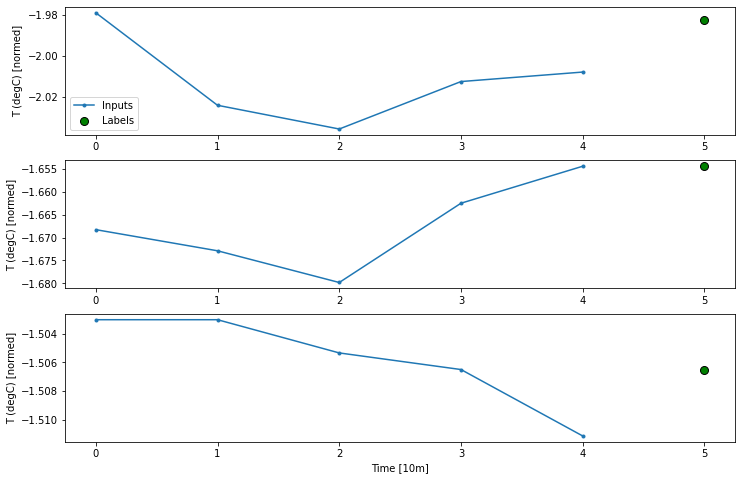

In [31]:
example_window2.plot()

`plot`에 추가적인 입력이 없는 경우, 기본적으로 `T deg(C)`에 대해 그래프를 그립니다. <br> 만약 다른 특성에 대한 그래프를 그리려면 `plot_col`을 지정해줍니다. <br> 다만, 이 경우 다른 특성에 대해 입력(input)과 라벨(label)을 구분하지 않았기 때문에, 그래프에서도 `T deg(C)`를 그린 그래프처럼 입력(input)과 라벨(label)에 대한 구분이 존재하지 않습니다.

이를 활용하여 `p (mbar)`에 대한 그래프를 그려보겠습니다.

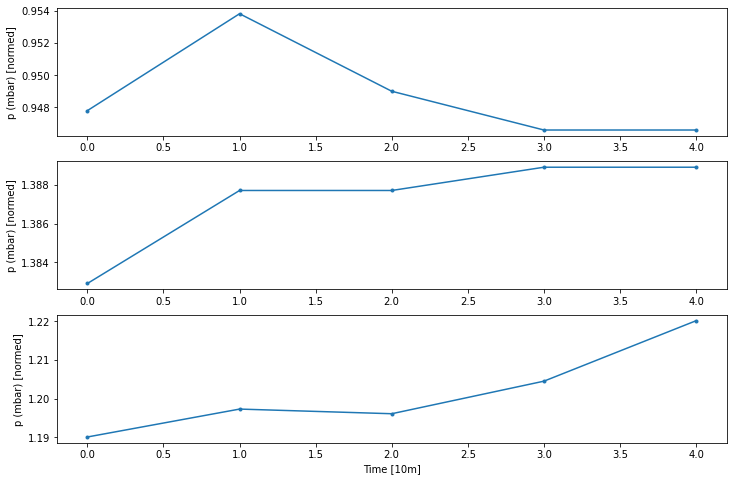

In [32]:
example_window2.plot(plot_col = 'p (mbar)')

---
마지막으로 `Window`클래스에 추가할 `make_dataset`함수를 정의합니다.

`make_dataset`함수는 `DataFrame`에 대해서 `preprocessing.timeseries_dataset_from_array`함수를 사용하여, 데이터를 `(input_window, label_window)`로 이루어져 있는 `tf.data.Dataset`으로 변환합니다.

In [35]:
def make_dataset(self, data) :
    data = np.array(data, dtype = np.float32)
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data, targets = None, sequence_length = self.total_width,
        sequence_stride = 1, shuffle = True, batch_size = 32)
    
    dataset = dataset.map(self.Split)
    
    return dataset

Window.make_dataset = make_dataset

`make_dataset`을 사용하고, 변수들의 호환성을 위하여 `@property`를 사용합니다.

In [36]:
@property
def train(self) :
    return self.make_dataset(self.train_scaled)

@property
def val(self) :
    return self.make_dataset(self.val_scaled)

@property
def test(self) :
    return self.make_dataset(self.test_scaled)

Window.train = train
Window.val = val
Window.test = test

---
## Single step models

![Single Step Models](images/03_singlestepmodel.PNG)

In [37]:
single_step_window = Window(input_width = 1, label_width = 1, offset = 1, label_columns = ['T (degC)'])

In [38]:
single_step_window

Total Width : 2
Input indices : [0]
Label indices : [1]
Label column name(s) : ['T (degC)']